idea:
sample the random parameters from distribution & solve the corresponding LP - repeat multiple times (monte carlo simulation...)


How to handle the binary variable x4? As it is only one, run a loop with x4=0 and one with x4=1 for each monte-carlo sampling step.

In [1]:
from scipy.optimize import linprog
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import numpy as np

## 1) test sampling from distributions
random sample x3 (uniform dist)

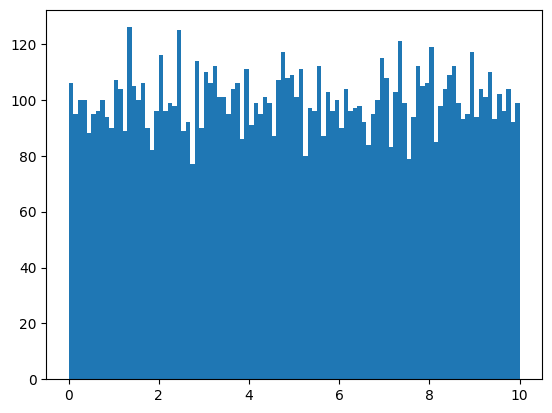

In [2]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    val[i] = np.random.uniform(0,10)
plt.hist(val,bins=100);

random sample from gamma dist

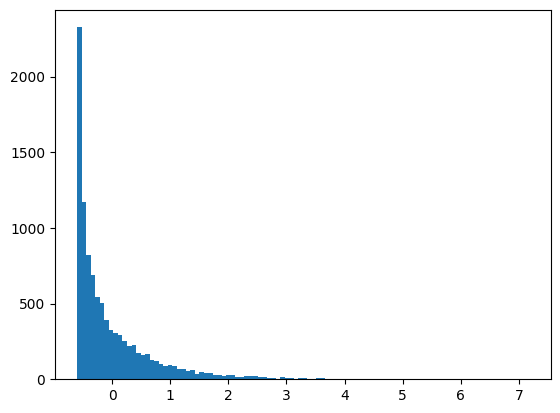

In [3]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    val[i] = gamma.rvs(0.6,scale=1)-0.6
plt.hist(val,bins=100);

random sample from R distribution (combine uniform dist for x3 and gamma dist)

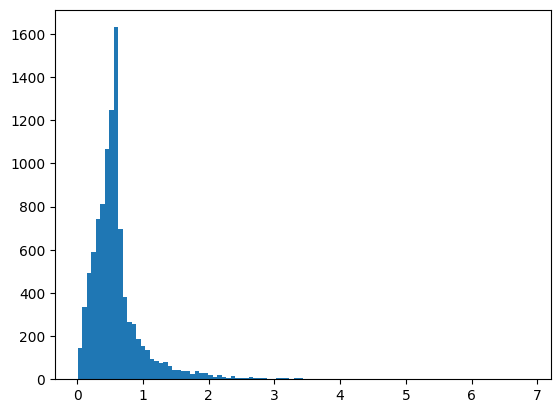

In [4]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    x3 = np.random.uniform(0,10)
    val[i] = 0.6 + (gamma.rvs(0.6,scale=1)-0.6)*(1-x3/10)
plt.hist(val,bins=100);

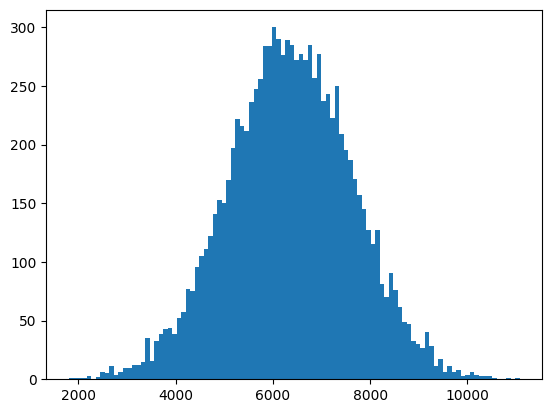

In [5]:
N=10000
val=np.zeros(N)
for i in range(0,N):
    val[i] = norm.rvs(6350,scale=1270)
plt.hist(val,bins=100);

## 2) implement optimization with monte-carlo sampling

x3, R & C are sampled randomly

for each sample, the optimization problem is solved for x4=0 & x4=1.

In [ ]:
N_mc = 10000
num_rep = 10
opt_profit_rep = np.zeros(num_rep)
opt_sol_rep=np.zeros((num_rep,4))
for rep in range(0,num_rep):
    opt_sol=np.zeros((N_mc*2,4))
    opt_profit=np.zeros(N_mc*2)
    cnt=0
    opt_rand_var=np.zeros((N_mc*2,2))

    for i in range(0,N_mc):
        x3_rand = np.random.uniform(0,10)
        R_rand = 0.6+(gamma.rvs(0.6,scale=1)-0.6)*(1-x3_rand/10)
        C_rand = norm.rvs(6350,scale=1270)
        for x4 in range(0,2):
            C_rand = np.max((C_rand,5200*x4))

            objective = [-250,-300]
            lhs_ineq = [[0.4,R_rand],
                        [3,2.5],
                        [1.27,1.27]]
            rhs_ineq = [[2500],
                        [14000],
                        [C_rand]]

            bnd = [ (0, float("inf")),
                    (0, float("inf"))]
            opt = linprog(c=objective, A_ub=lhs_ineq, b_ub=rhs_ineq,bounds=bnd,method="highs")

            opt_sol[cnt,:] = np.concatenate((opt.x, [x3_rand], [x4]))
            opt_profit[cnt] = opt.fun*-1 - 470*x3_rand - 30e3*x4
            opt_rand_var[cnt,:] = np.array([R_rand,C_rand])
            cnt +=1
    # print best solution
    idx=np.argmax(opt_profit)
    print(idx)
    print("Optimal solution: [x1,x2,x3,x4] = ", opt_sol[idx,:])
    print("Optimal profit: ", opt_profit[idx],'$')
    opt_profit_rep[rep] = opt_profit[idx]
    opt_sol_rep[rep,:] = opt_sol[idx,:]

248
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 2.03120282e-02 0.00000000e+00]
Optimal profit:  1679990.4533467575 $
19358
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 8.48516078e-04 0.00000000e+00]
Optimal profit:  1679999.6011974434 $
2550
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 2.84745207e-03 0.00000000e+00]
Optimal profit:  1679998.6616975274 $
2336
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 1.19488437e-02 0.00000000e+00]
Optimal profit:  1679994.3840434686 $
178
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 1.05855566e-04 0.00000000e+00]
Optimal profit:  1679999.9502478838 $
3098
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 1.79446787e-03 0.00000000e+00]
Optimal profit:  1679999.1566001007 $
15636
Optimal solution: [x1,x2,x3,x4] =  [0.00000000e+00 5.60000000e+03 8.75796909e-03 0.00000000e+00]
Optimal profit:  1679995.8837545265 $
17032
Optimal soluti

In [12]:
print(f'note, one repetition contains {N_mc} samples of (x3,R,C) and 2 optimizations each (x4=0,1)')
print("Average optimal profit over ",num_rep," repetitions: ", np.mean(opt_profit_rep),"+/-",np.std(opt_profit_rep),'$')
print("Average optimal x1 over ",num_rep," repetitions: ", np.mean(opt_sol_rep[:,0]),"+/-",np.std(opt_sol_rep[:,0]),'tons')
print("Average optimal x2 over ",num_rep," repetitions: ", np.mean(opt_sol_rep[:,1]),"+/-",np.std(opt_sol_rep[:,1]),'tons')
print("Average optimal x3 over ",num_rep," repetitions: ", np.mean(opt_sol_rep[:,2]),"+/-",np.std(opt_sol_rep[:,2]),'tons')
if (opt_sol_rep[:,3]==1).all():
    print("optimal x4 over ",num_rep," repetitions was always 1 --> use the carrier capacity guarantee!")
else:
    if (opt_sol_rep[:,3]==0).all():
        print("optimal x4 over ",num_rep," repetitions was always 0 --> do not use the carrier capacity guarantee!")
    else:
        print("optimal x4 over ",num_rep," repetitions was mixed!")

note, one repetition contains 10000 samples of (x3,R,C) and 2 optimizations each (x4=0,1)
Average optimal profit over  10  repetitions:  1679997.208222711 +/- 2.8690487058674976 $
Average optimal x1 over  10  repetitions:  0.0 +/- 0.0 tons
Average optimal x2 over  10  repetitions:  5600.0 +/- 0.0 tons
Average optimal x3 over  10  repetitions:  0.005939951678544775 +/- 0.0061043589487337945 tons
optimal x4 over  10  repetitions was always 0 --> do not use the carrier capacity guarantee!


check distribution of R&C

Text(0.5, 1.0, 'Distribution of R')

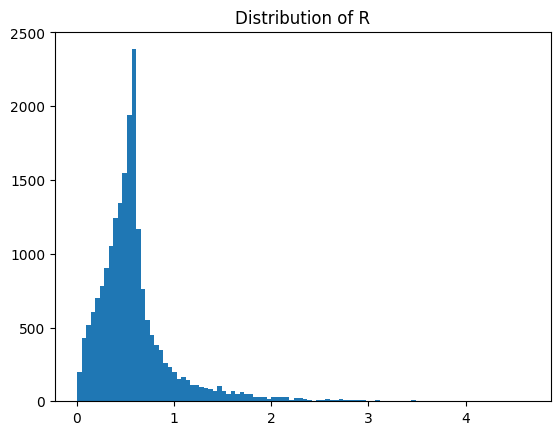

In [7]:
plt.hist(opt_rand_var[:,0],bins=100);
plt.title('Distribution of R')

Text(0.5, 1.0, 'Distribution of C')

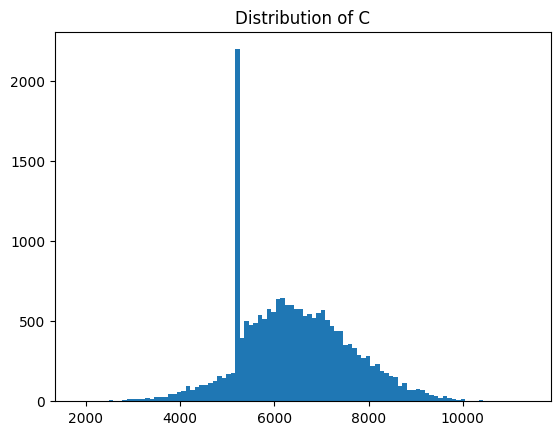

In [8]:
plt.hist(opt_rand_var[:,1],bins=100);
plt.title('Distribution of C')